In [1]:
import os, sys, datetime, json, numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tkz

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from supervisedlearning.approximation import ApproximatedHeteroskedasticGaussianProcessRegressorRBF

from utils import make_json_serializable

Current path: /Users/marcomussi/git/HetGaussianProcesses


In [2]:
kernel_L_lst = [10]
epsilon_lst = [None, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
regularization_lst = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 200, 300, 500, 700, 1000]
regularization_lst = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000]
N_lst = [100, 200, 300, 500, 700, 1000]
N_lst = [200, 400, 600, 800, 1000]

n_samples_plt = 1000
x_plt = np.linspace(0, 1, n_samples_plt)

def exp_reward_values(xvect):
    return np.cos(xvect * 6.28 - 1)

dateformat = "(%Y-%b-%d %Ih%Mm%p)"
save_path = "results/supervised/approximation/"

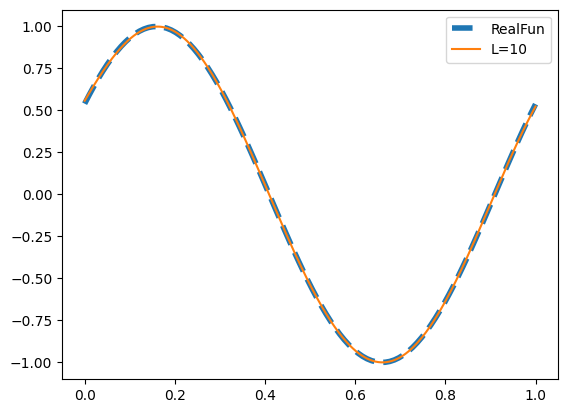

In [3]:
N_test = 100
reg = 0.01
x_vect = np.linspace(0, 1, N_test)
y_vect = exp_reward_values(x_vect)
x_vect = x_vect.reshape(N_test, 1)

plt.figure()
plt.plot(x_vect.ravel(), y_vect, "--", linewidth=4, label="RealFun")

for kernel_L in kernel_L_lst:

    regressor = ApproximatedHeteroskedasticGaussianProcessRegressorRBF(kernel_L, reg)
    regressor.load_data(x_vect, y_vect)
    y_hat, y_sigma = regressor.compute(x_plt.reshape(-1, 1))
    plt.plot(x_plt.ravel(), y_hat, label=f"L={kernel_L}")
    plt.fill_between(x_plt.ravel(), y_hat - y_sigma, y_hat + y_sigma, alpha=0.3)
                
plt.legend()

In [4]:
assert epsilon_lst[0] is None, "The first element of epsilon_lst should be None"
results = {}

for N in N_lst:
    results[N] = {}
    np.random.seed(0)
    # x_vect = np.random.uniform(0, 1, N) 
    x_vect = np.linspace(0, 1, N)
    y_vect = exp_reward_values(x_vect)
    x_vect = x_vect.reshape(N, 1)
        
    for kernel_L in kernel_L_lst:
        results[N][kernel_L] = {}

        for regularization in regularization_lst:
            results[N][kernel_L][regularization] = {}
            y_hat, y_sigma = {}, {}
            # plt.figure()
            # plt.plot(x_plt.ravel(), exp_reward_values(x_plt.ravel()), "--", linewidth=4, label="RealFun")

            for epsilon in epsilon_lst:
                results[N][kernel_L][regularization][epsilon] = {}
                regressor = ApproximatedHeteroskedasticGaussianProcessRegressorRBF(kernel_L, regularization, epsilon=epsilon)
                regressor.load_data(x_vect, y_vect)
                y_hat[epsilon], y_sigma[epsilon] = regressor.compute(x_plt.reshape(-1, 1))
                results[N][kernel_L][regularization][epsilon]["errorinfnorm"] = np.round(max(np.abs(y_hat[epsilon] - y_hat[None])), 5)
                results[N][kernel_L][regularization][epsilon]["errorinfnormvar"] = np.round(max(np.abs(y_sigma[epsilon] - y_sigma[None])), 5)
                results[N][kernel_L][regularization][epsilon]["nsample"] = regressor.cover_x.shape[0] if epsilon is not None else None
                # label = f"$\epsilon$={epsilon} - $|C|$={regressor.cover_x.shape[0]}" if epsilon is not None else f"$\mu$"
                # plt.plot(x_plt.ravel(), y_hat[epsilon], label=label)
                # plt.fill_between(x_plt.ravel(), y_hat[epsilon] - y_sigma[epsilon], y_hat[epsilon] + y_sigma[epsilon], alpha=0.3)
                
            # plt.legend()
            # plt.title(f"N{N}_L{kernel_L}_reg{regularization}")

In [5]:
for N in N_lst:
    for kernel_L in kernel_L_lst:
        for regularization in regularization_lst:
            for epsilon in epsilon_lst:
                print(f"N = {N} - kernel_L = {kernel_L} - $\lambda$ = {regularization} - $\epsilon$ = {epsilon} \t Error = {results[N][kernel_L][regularization][epsilon]['errorinfnorm']}    \t Cover Size = {results[N][kernel_L][regularization][epsilon]['nsample']}")

serializable_dict = make_json_serializable(results)
complete_path_json = f"{save_path}N{N_lst}_kernelL{kernel_L_lst}_reg{regularization_lst}_eps{epsilon_lst}_{datetime.datetime.now().strftime(dateformat)}.json"
with open(complete_path_json, "w", encoding="utf-8") as filejson:
    json.dump(serializable_dict, filejson, ensure_ascii=False, indent=4)

N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = None 	 Error = 0.0    	 Cover Size = None
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.02 	 Error = 0.00117    	 Cover Size = 249
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.05 	 Error = 0.00568    	 Cover Size = 99
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.1 	 Error = 0.00303    	 Cover Size = 49
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.2 	 Error = 0.00669    	 Cover Size = 24
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.3 	 Error = 0.01736    	 Cover Size = 16
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.4 	 Error = 0.03655    	 Cover Size = 11
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.5 	 Error = 0.06602    	 Cover Size = 9
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.6 	 Error = 0.10409    	 Cover Size = 7
N = 200 - kernel_L = 10 - $\lambda$ = 2 - $\epsilon$ = 0.7 	 Error = 0.13712    	 Cover Size = 6
N = 200 - kernel_L = 

/var/folders/4z/mvrgdd8923g26xd4nhj_0gdh0000gn/T/ipykernel_10989/3466919063.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


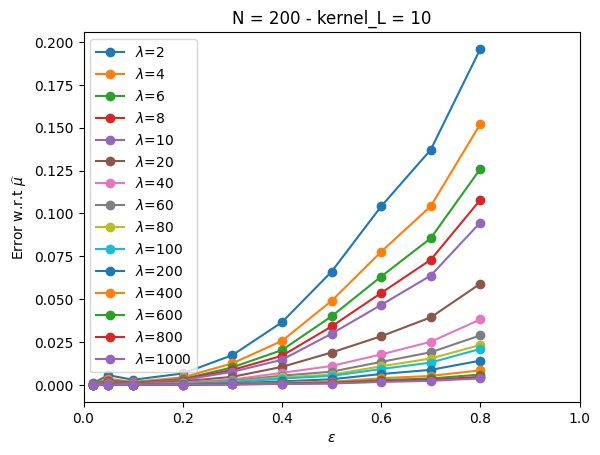

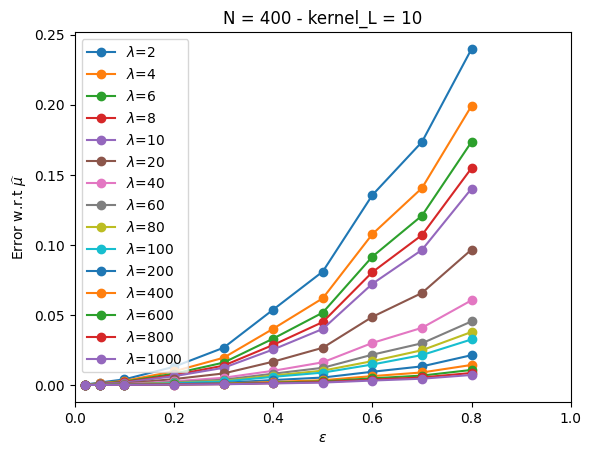

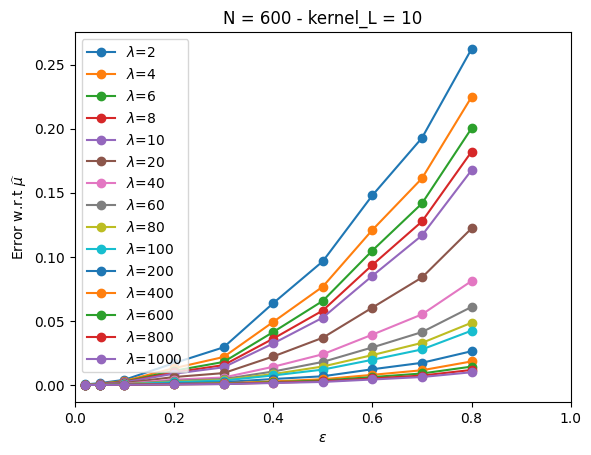

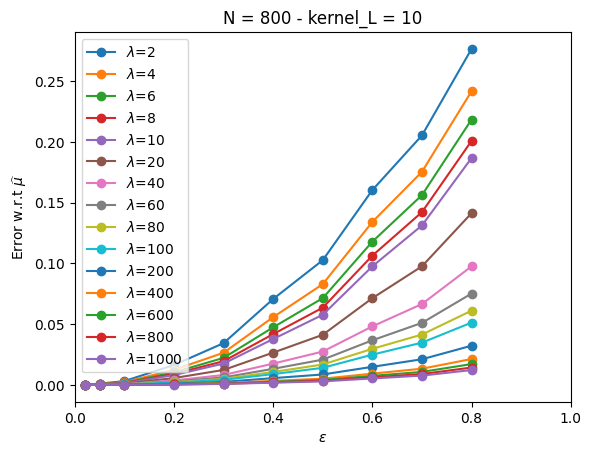

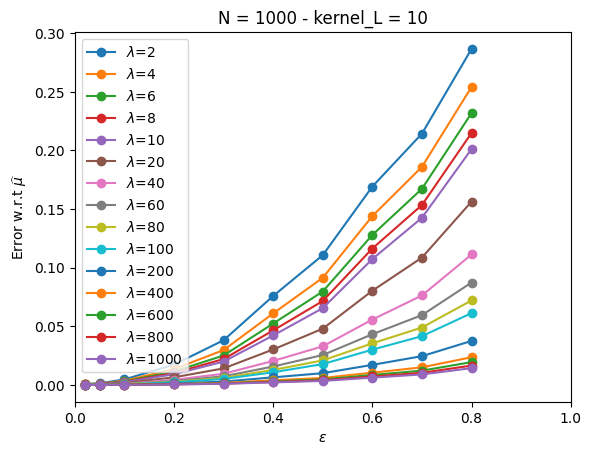

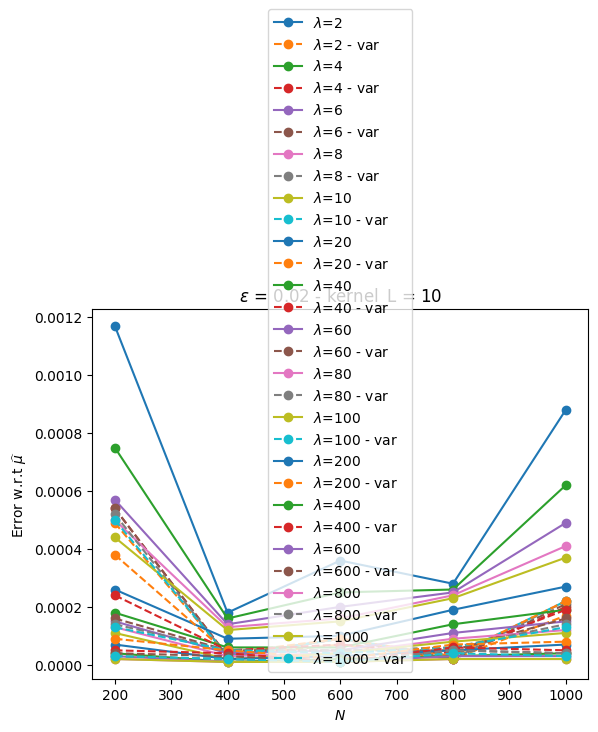

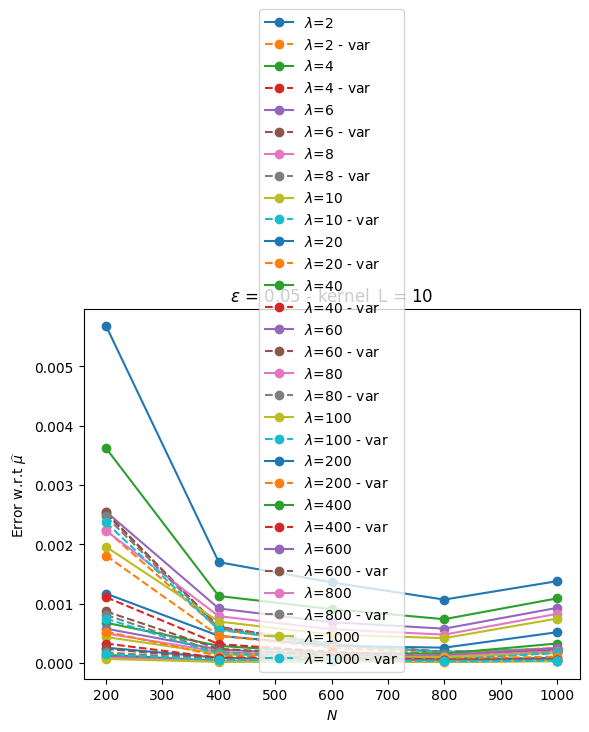

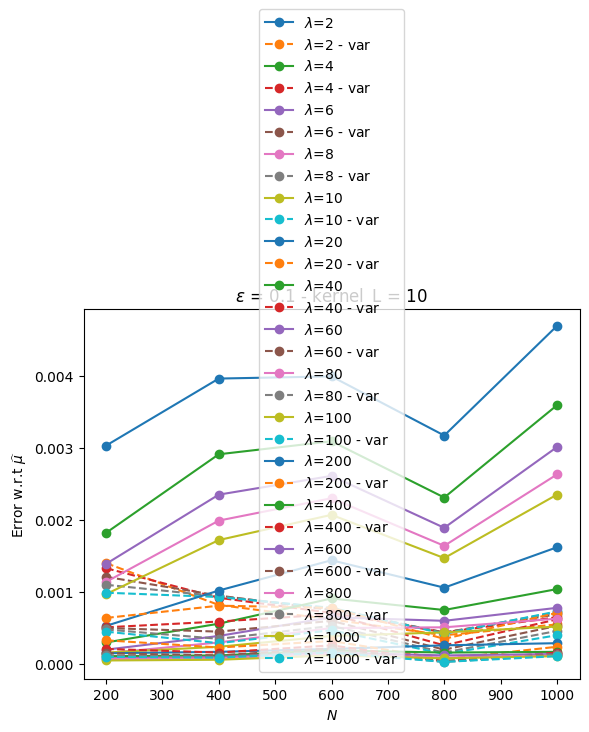

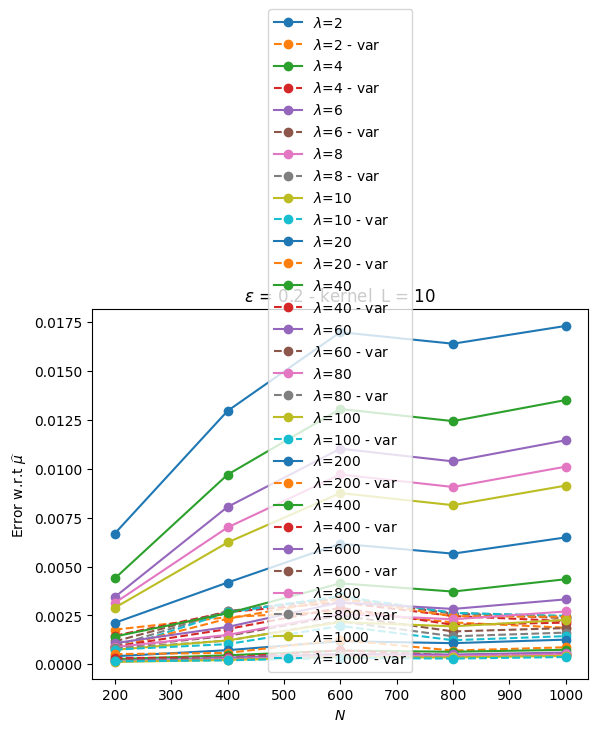

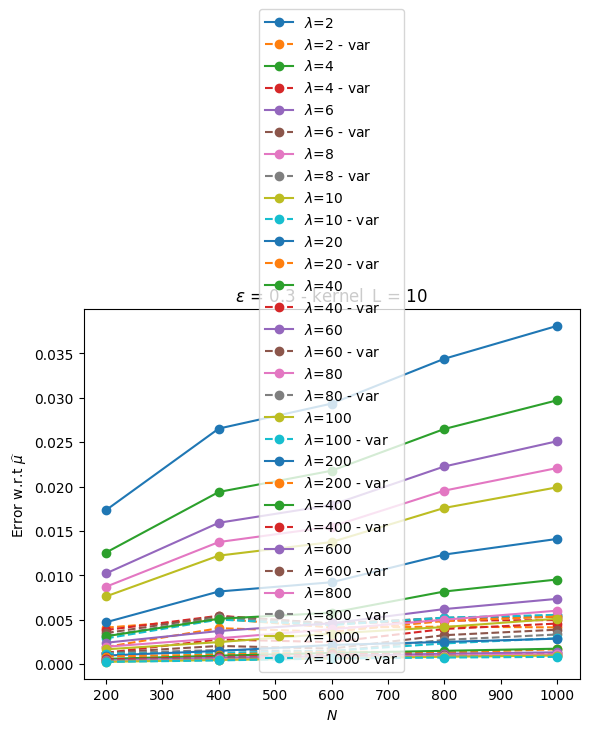

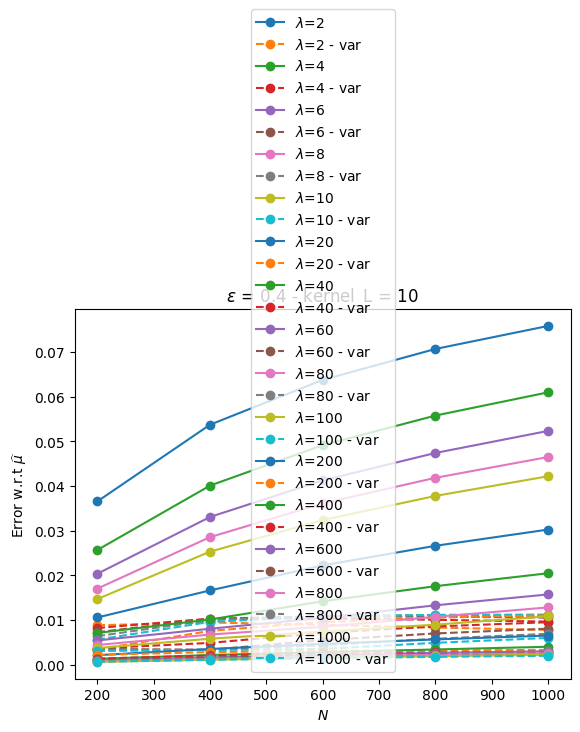

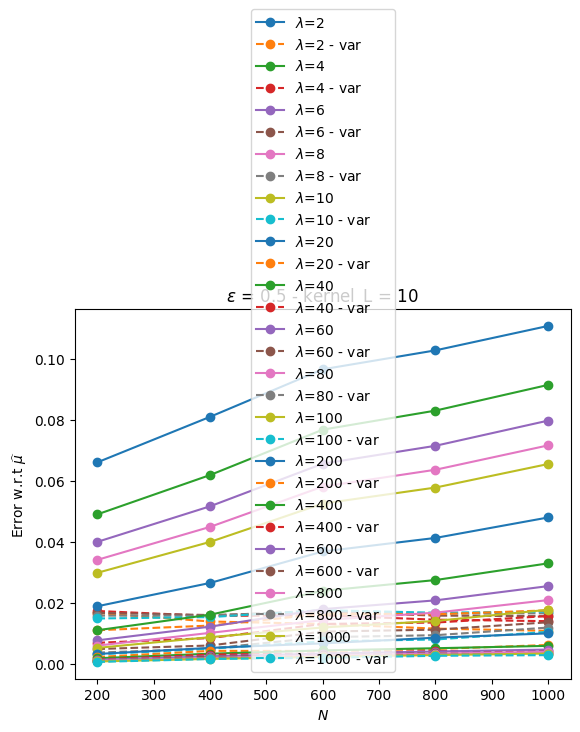

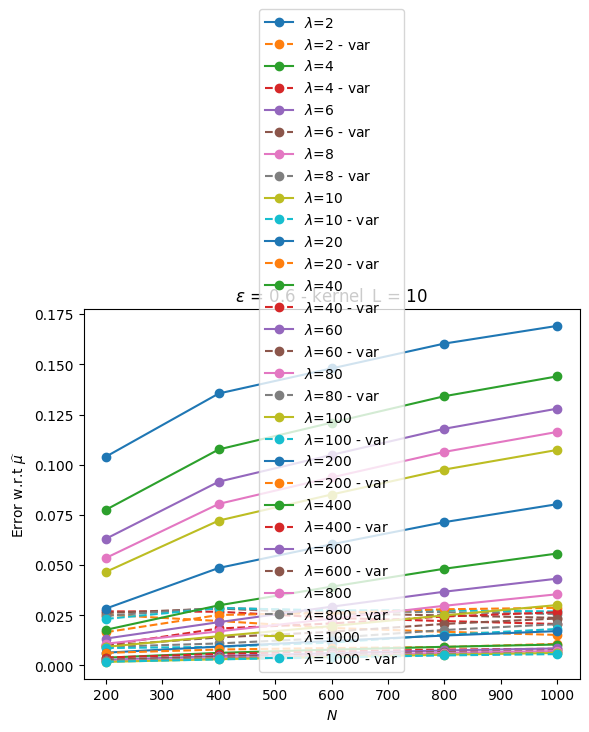

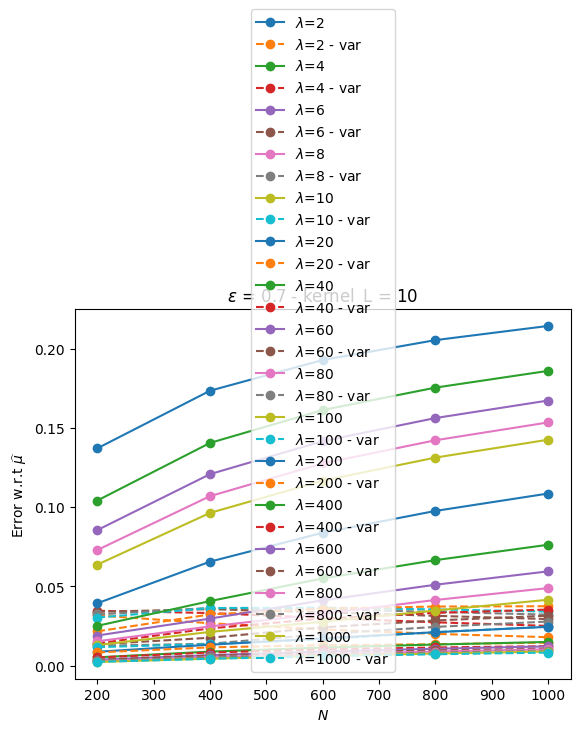

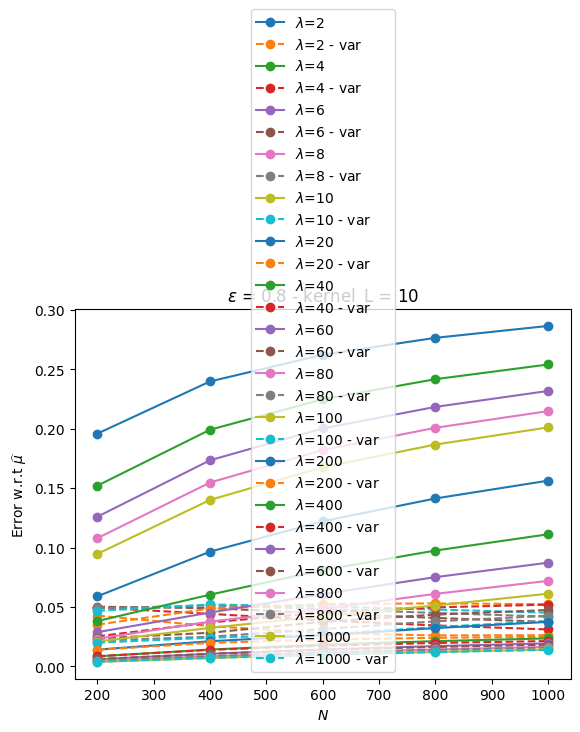

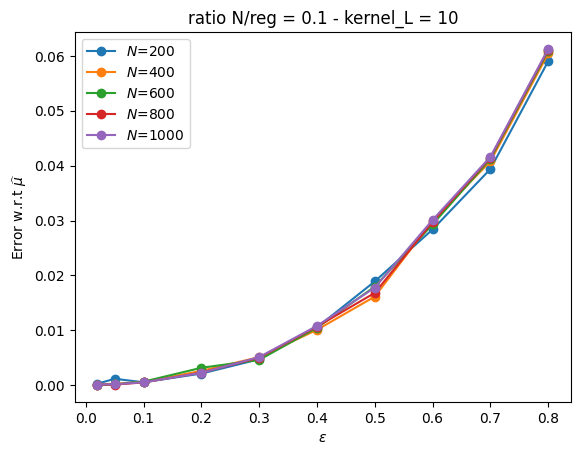

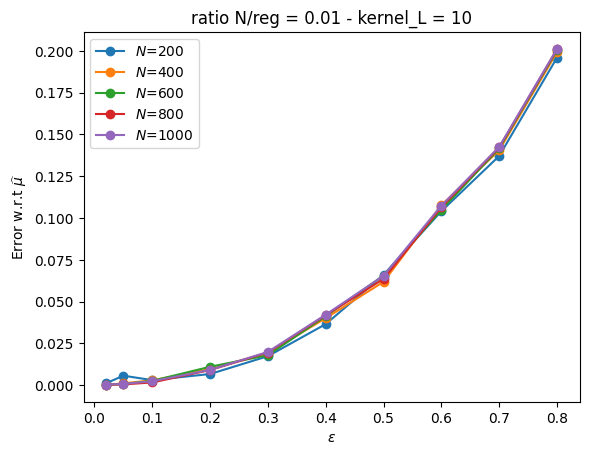

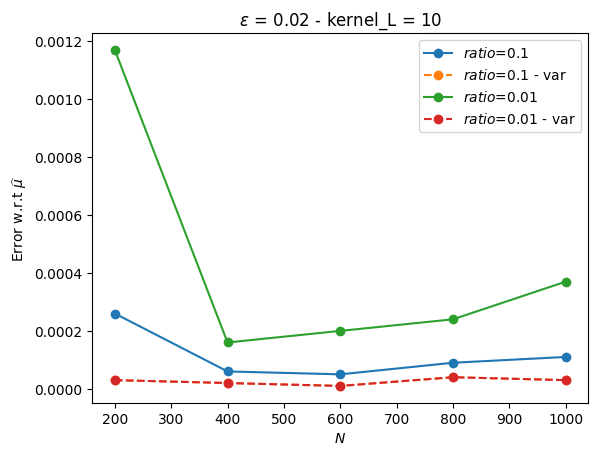

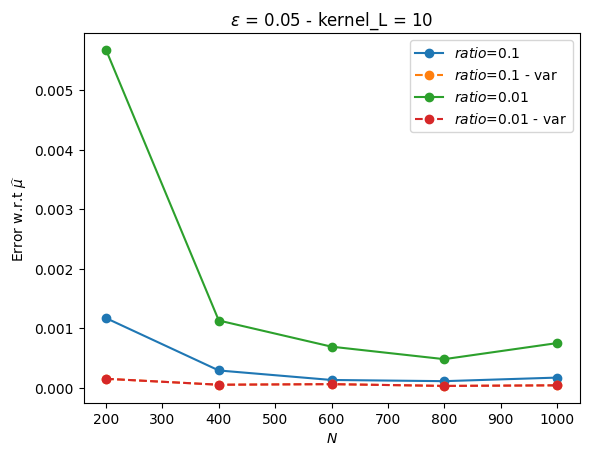

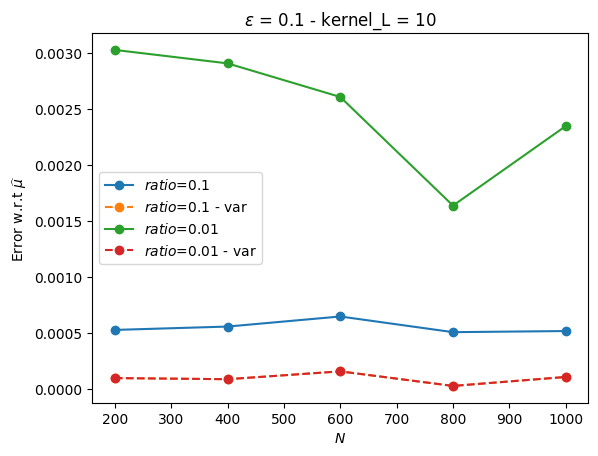

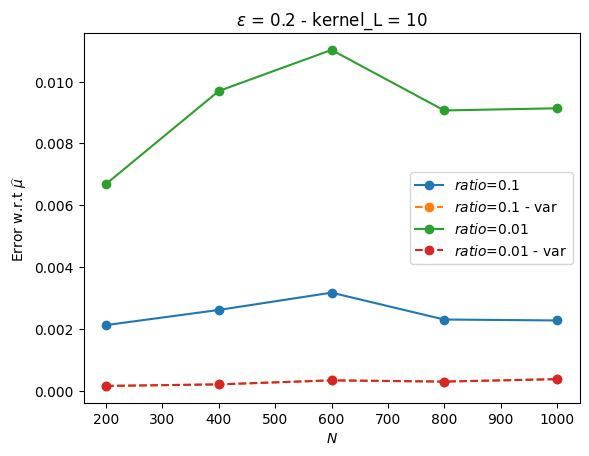

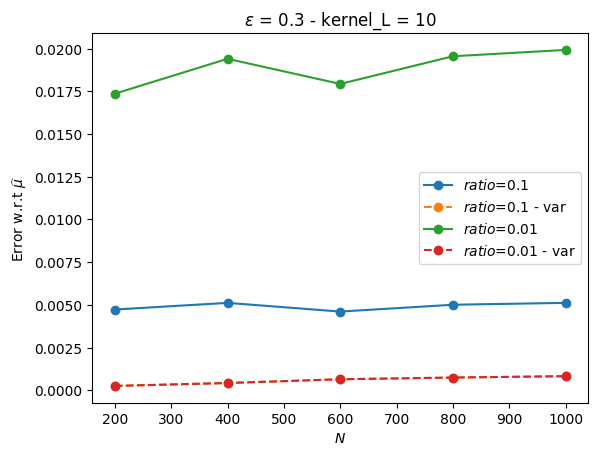

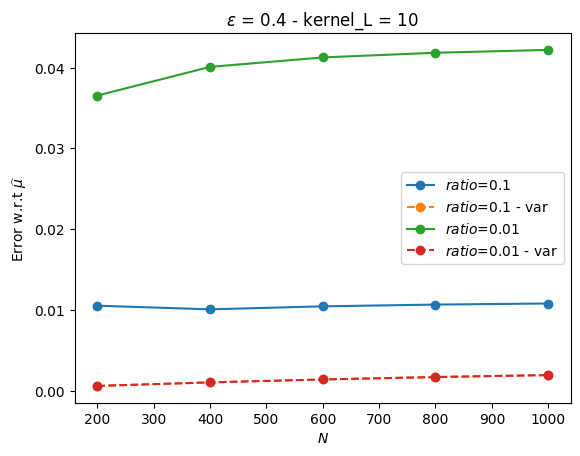

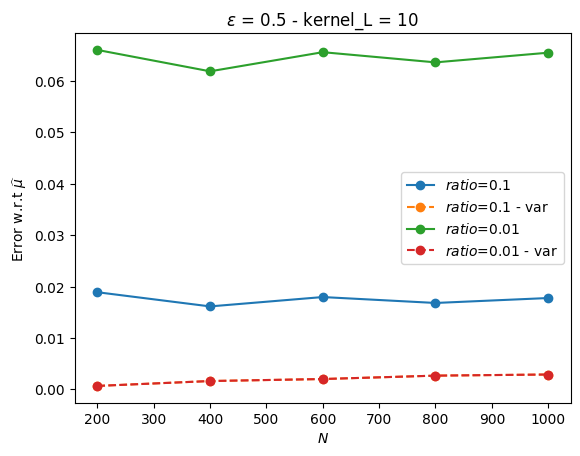

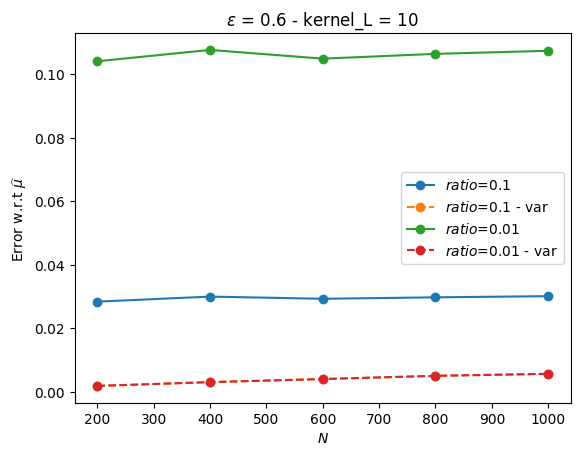

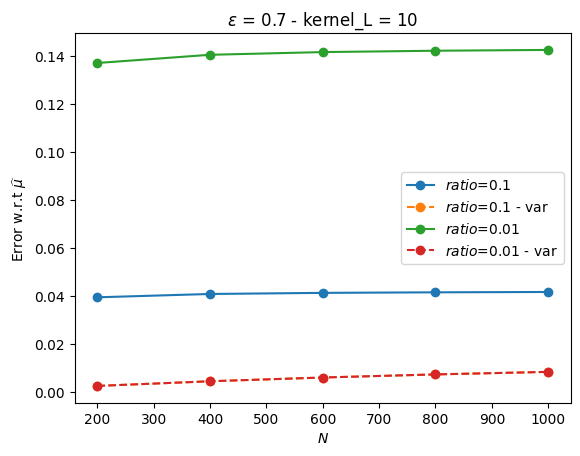

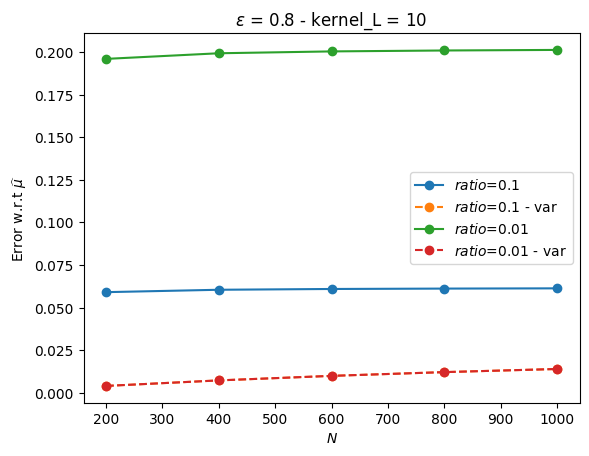

In [6]:
save = True

epsilon_vect = np.array(epsilon_lst[1:])
N_vect = np.array(N_lst)

# reg fissa
# forall N forall kernel_L
# for every lambda plot infnorm-error varying epsilon

for N in N_lst:
    for kernel_L in kernel_L_lst:
        plt.figure()
        plt.title(f"N = {N} - kernel_L = {kernel_L}")
        for regularization in regularization_lst:
            err_vect = -1 * np.ones((len(epsilon_lst)-1))
            for eps_i, epsilon in enumerate(epsilon_lst[1:]): 
                err_vect[eps_i] = results[N][kernel_L][regularization][epsilon]['errorinfnorm']
            plt.plot(epsilon_vect, err_vect, "o-", label=f"$\lambda$={regularization}")
        plt.xlim([0, 1])
        plt.xlabel("$\epsilon$")
        plt.ylabel("Error w.r.t $\widehat{\mu}$") 
        plt.legend(loc="best")
        if save:
            complete_path = f"{save_path}N{N}_L{kernel_L}_reglst{regularization_lst}_epslst{epsilon_lst}_{datetime.datetime.now().strftime(dateformat)}"
            plt.savefig(f"{complete_path}.jpg")
            tkz.save(f"{complete_path}.tex")


# reg fissa
# forall eps forall kernel_L
# for every lambda plot infnorm-error varying N

for kernel_L in kernel_L_lst:
    for epsilon in epsilon_lst[1:]:
        plt.figure()
        plt.title(f"$\epsilon$ = {epsilon} - kernel_L = {kernel_L}")
        for regularization in regularization_lst:
            err_vect = -1 * np.ones((len(N_lst)))
            err_vect_postvariance = -1 * np.ones((len(N_lst)))
            for N_i, N in enumerate(N_lst): 
                err_vect[N_i] = results[N][kernel_L][regularization][epsilon]['errorinfnorm']
                err_vect_postvariance[N_i] = results[N][kernel_L][regularization][epsilon]['errorinfnormvar']
            plt.plot(N_vect, err_vect, "o-", label=f"$\lambda$={regularization}")
            plt.plot(N_vect, err_vect_postvariance, "o--", label=f"$\lambda$={regularization} - var")
        # plt.xlim([0, 1])
        plt.xlabel("$N$")
        plt.ylabel("Error w.r.t $\widehat{\mu}$") 
        plt.legend(loc="best")
        if save:
            complete_path = f"{save_path}eps{epsilon}_L{kernel_L}_reglst{regularization_lst}_Nlst{N_lst}_{datetime.datetime.now().strftime(dateformat)}"
            plt.savefig(f"{complete_path}.jpg")
            tkz.save(f"{complete_path}.tex")


# N/reg fissa
# forall ratios forall kernel_L
# for every lambda plot infnorm-error varying N

for kernel_L in kernel_L_lst:
    for ratio in [1/10, 1/100]:
        plt.figure()
        plt.title(f"ratio N/reg = {ratio} - kernel_L = {kernel_L}")
        for N in N_lst:
            err_vect = -1 * np.ones((len(epsilon_lst)-1))
            for eps_i, epsilon in enumerate(epsilon_lst[1:]): 
                err_vect[eps_i] = results[N][kernel_L][int(N*ratio)][epsilon]['errorinfnorm']
            plt.plot(epsilon_vect, err_vect, "o-", label=f"$N$={N}")
        plt.xlabel("$\epsilon$")
        plt.ylabel("Error w.r.t $\widehat{\mu}$") 
        plt.legend(loc="best")
        if save:
            complete_path = f"{save_path}ratio{ratio}_L{kernel_L}_Nlst{N_lst}_reglst{regularization_lst}_epslst{epsilon_lst}_{datetime.datetime.now().strftime(dateformat)}"
            plt.savefig(f"{complete_path}.jpg")
            tkz.save(f"{complete_path}.tex")


# N/reg fissa
# forall eps forall kernel_L
# for every lambda plot infnorm-error varying N

for kernel_L in kernel_L_lst:
    for epsilon in epsilon_lst[1:]:
        plt.figure()
        plt.title(f"$\epsilon$ = {epsilon} - kernel_L = {kernel_L}")
        for ratio in [1/10, 1/100]:
            err_vect = -1 * np.ones((len(N_lst)))
            err_vect_postvariance = -1 * np.ones((len(N_lst)))
            for N_i, N in enumerate(N_lst): 
                err_vect[N_i] = results[N][kernel_L][int(N*ratio)][epsilon]['errorinfnorm']
                err_vect_postvariance[N_i] = results[N][kernel_L][regularization][epsilon]['errorinfnormvar']
            plt.plot(N_vect, err_vect, "o-", label=f"$ratio$={ratio}")
            plt.plot(N_vect, err_vect_postvariance, "o--", label=f"$ratio$={ratio} - var")
        plt.xlabel("$N$")
        plt.ylabel("Error w.r.t $\widehat{\mu}$") 
        plt.legend(loc="best")
        if save:
            complete_path = f"{save_path}eps{epsilon}_L{kernel_L}_reglst{regularization_lst}_Nlst{N_lst}_ratios_{datetime.datetime.now().strftime(dateformat)}"
            plt.savefig(f"{complete_path}.jpg")
            tkz.save(f"{complete_path}.tex")